## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
def DB_index(X, labels, centres):
    k = np.unique(labels).size
    s = np.array([])
    for i in range(k):
        mask = (labels == i)
        s = np.append(s, np.sqrt(np.sum((X[mask] - centres[i])**2)/X[mask].shape[0]))
    m = np.sqrt(((centres - centres[:, np.newaxis, :])**2).sum(axis=2))
    r = np.divide((s + s[np.newaxis, :]), m)
    np.fill_diagonal(r, -np.inf)
    return sum(r.max(axis=1))/k

In [3]:
def dunn_index(X, labels, centres):
    m = np.sqrt(((centres - centres[:, np.newaxis, :])**2).sum(axis=2))
    np.fill_diagonal(m, np.inf)
    k = np.unique(labels).size
    s = np.array([])
    for i in range(k):
        cluster_data = X[labels == i]
        s = np.append(s, np.max(np.sqrt((cluster_data - cluster_data[:, np.newaxis, :])**2)))
    return np.min(m)/max(s)

In [4]:
import matplotlib.colors as colors
from itertools import cycle

def plotClustering(X, plt_labels, plot_noise=False):
    plt_colors = cycle(colors.cnames.keys())

    plt_K = np.unique(plt_labels).size

    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=color, marker='o')
    
    if plot_noise:
        mask = (plt_labels == -1)
        plt.scatter(X[mask, 0], X[mask, 1], marker='x', c='r', alpha=0.8)

    plt.show()

def plotBirchClustering(X, birch):
    plt_colors = cycle(colors.cnames.keys())

    plt_K = np.unique(birch.labels_).size

    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (birch.labels_ == k)
        plt.scatter(X[mask, 0], X[mask, 1], c=color, edgecolors='none', alpha=0.5)
    plt.scatter(birch.root_.centroids_[:, 0], birch.root_.centroids_[:, 1], marker='x', c='black')
    
    plt.show()

## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

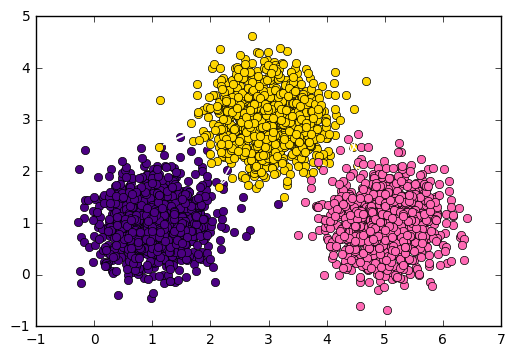

In [17]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X, labels)

### Grupowanie za pomocą KMeans

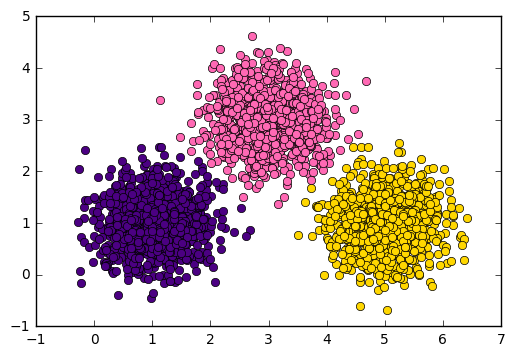

Silhouette: 0.67216643675
DB Index: 0.507034635829
Dunn Index: 0.789956018736


In [25]:
"""
n_init -- number of time the k-means algorithm will be run with different centroid seeds.
The final results will be the best output of n_init consecutive runs in terms of inertia.
"""
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

plotClustering(X, k_means.labels_)

print "Silhouette:", silhouette_score(X, k_means.labels_, metric='euclidean')
print "DB Index:", DB_index(X, k_means.labels_, k_means.cluster_centers_)
print "Dunn Index:", dunn_index(X, k_means.labels_, k_means.cluster_centers_)

### Grupowanie za pomocą MiniBatchKMeans

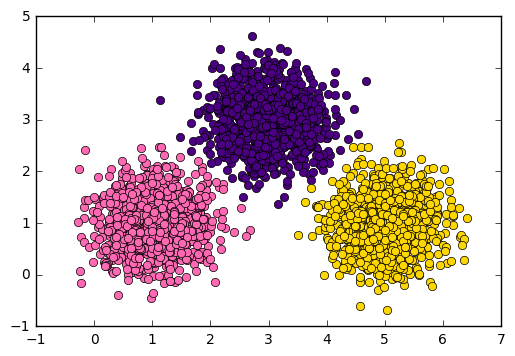

Silhouette: 0.67216643675
DB Index: 0.505252880956
Dunn Index: 0.790632625385


In [24]:
import warnings
warnings.filterwarnings("ignore")
mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=1, max_no_improvement=10, verbose=0, random_state=0)
mini_batch_k_means.fit(X)

plotClustering(X, mini_batch_k_means.labels_)
print "Silhouette:", silhouette_score(X, mini_batch_k_means.labels_, metric='euclidean')
print "DB Index:", DB_index(X, mini_batch_k_means.labels_, mini_batch_k_means.cluster_centers_)
print "Dunn Index:", dunn_index(X, mini_batch_k_means.labels_, mini_batch_k_means.cluster_centers_)

### Grupowanie za pomocą Birch bez wtórnego grupowania

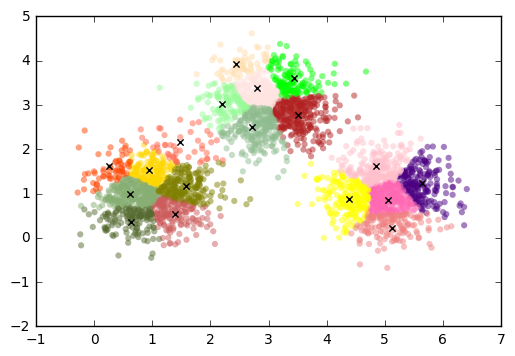

Silhouette: 0.302217850216
Dunn Index: 0.353829821043


In [27]:
# treshold -- The radius of the subcluster obtained by merging a new sample 
# and the closest subcluster should be lesser than the threshold.
# Otherwise a new subcluster is started.

birch = Birch(threshold=0.5, n_clusters=None)
birch.fit(X)

plotBirchClustering(X, birch)
print "Silhouette:", silhouette_score(X, birch.labels_, metric='euclidean')
print "Dunn Index:", dunn_index(X, birch.labels_, birch.root_.centroids_)

### Grupowanie za pomocą Birch z wtórnym grupowaniem

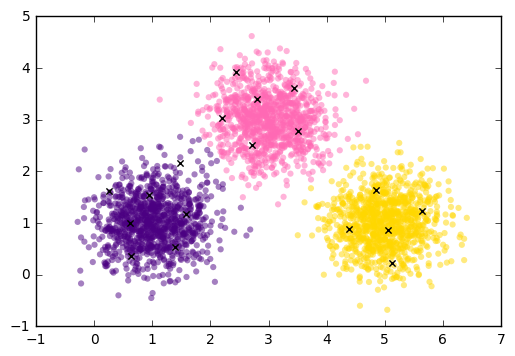

Silhouette: 0.670974674364


In [22]:
birch = Birch(threshold=0.5, n_clusters=3)
birch.fit(X)

plotBirchClustering(X, birch)
print "Silhouette:", silhouette_score(X, birch.labels_, metric='euclidean')

### Grupowanie za pomocą DBScan

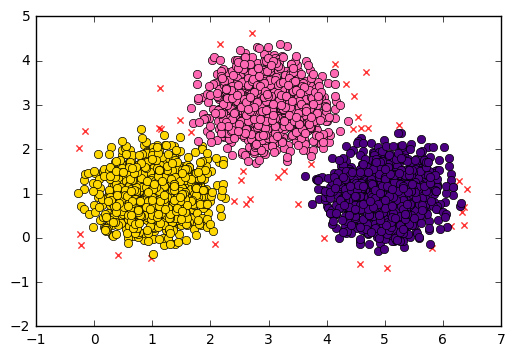

Silhouette: 0.656032242982


In [23]:
# eps -- The maximum distance between two samples for them to be considered as in the same neighborhood.

dbscan = DBSCAN(eps=0.35, min_samples=25)
dbscan.fit(X)

plotClustering(X, dbscan.labels_, plot_noise=True)
print "Silhouette:", silhouette_score(X, dbscan.labels_, metric='euclidean')

## 2. Drugi zestaw danych
Dane IRIS

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data

In [12]:
def plotIrisClustering(X, plt_labels, plot_noise=False):
    plt_K = np.unique(plt_labels).size

    fig, ax = plt.subplots(len(iris.feature_names), len(iris.feature_names), figsize=(10, 10))
    for i in range(len(iris.feature_names)):
        for j in range(len(iris.feature_names)):
            if i != j:
                plt_colors = cycle(colors.cnames.keys())
                for k in xrange(plt_K):
                    color = plt_colors.next()
                    mask = (plt_labels == k)
                    ax[j][i].plot(X[mask, i], X[mask, j], 'w', markerfacecolor=color, marker='o')

                if plot_noise:
                    mask = (plt_labels == -1)
                    ax[j][i].scatter(X[mask, i], X[mask, j], marker='x', c='r', alpha=0.8)
    
    for i in range(len(iris.feature_names)):
        ax[i][0].set_ylabel(iris.feature_names[i])
        ax[len(iris.feature_names) - 1][i].set_xlabel(iris.feature_names[i])

    plt.show()

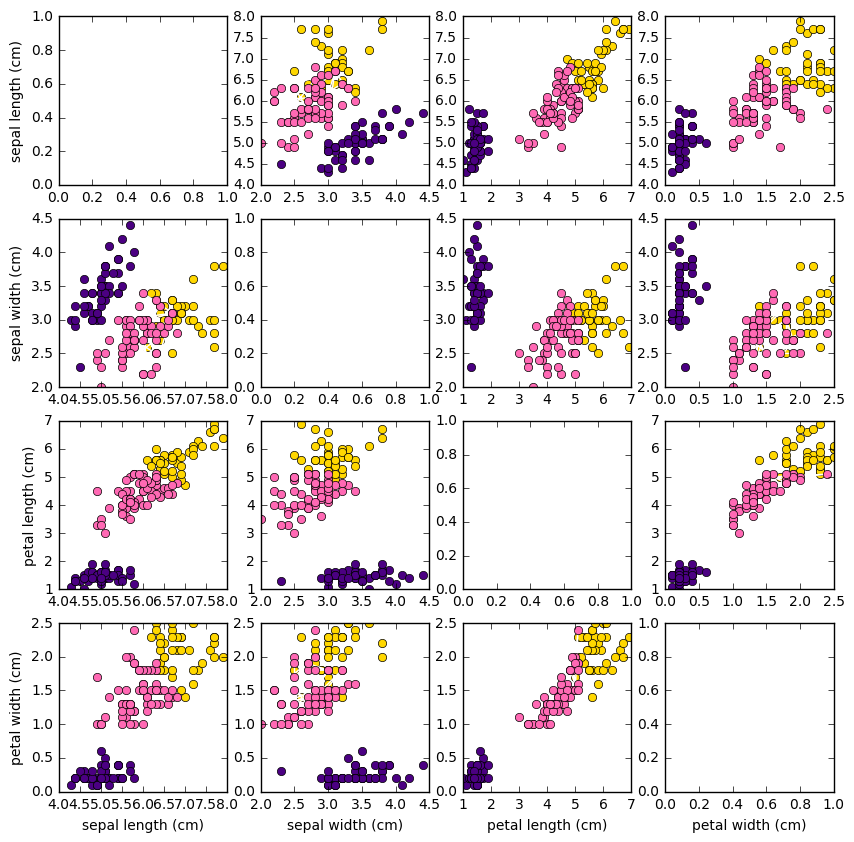

Silhouette: 0.550964374642
DB Index: 0.754090050244
Dunn Index: 0.812919792571


In [13]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

plotIrisClustering(X, k_means.labels_)

print "Silhouette:", silhouette_score(X, k_means.labels_, metric='euclidean')
print "DB Index:", DB_index(X, k_means.labels_, k_means.cluster_centers_)
print "Dunn Index:", dunn_index(X, k_means.labels_, k_means.cluster_centers_)

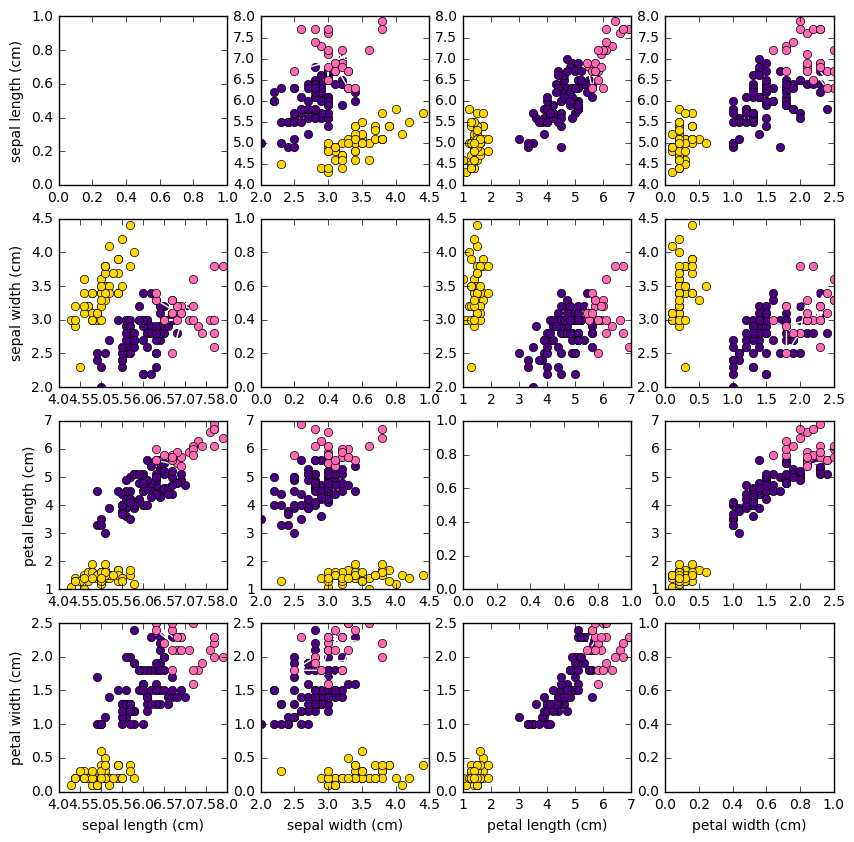

Silhouette: 0.550964374642


In [14]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

plotIrisClustering(X, birch.labels_)
print "Silhouette:", silhouette_score(X, k_means.labels_, metric='euclidean')

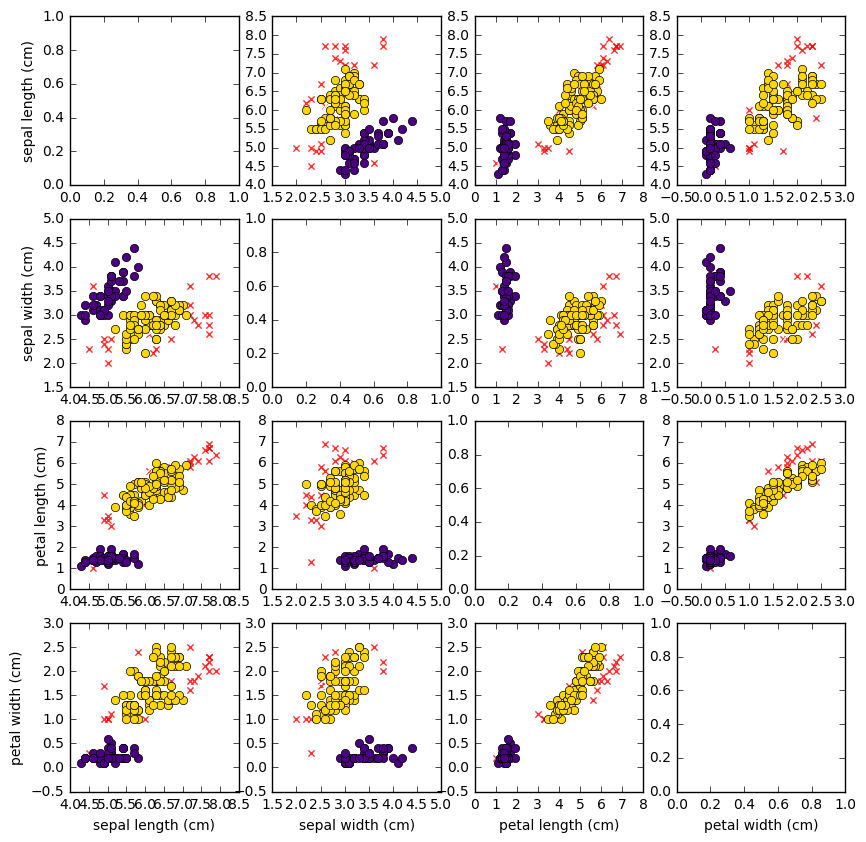

Silhouette: 0.459614808116


In [15]:
dbscan = DBSCAN(eps=0.45, min_samples=5)
dbscan.fit(X)

plotIrisClustering(X, dbscan.labels_, plot_noise=True)
print "Silhouette:", silhouette_score(X, dbscan.labels_, metric='euclidean')